<a href="https://colab.research.google.com/github/Zundock/Deep-whaling/blob/master/deep_learning_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This kernal was used as a base for this code https://www.kaggle.com/hrmello/flow-from-dataframe-a-memory-friendly-approach
  
from googleapiclient.discovery import build
import io, os, cv2, csv
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from skimage.io import imread

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import concatenate, Conv2DTranspose, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Concatenate
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [8]:
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)



!pip install kaggle


Download 100%.


In [9]:
# if not os.path.exists('./data'):
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json
if (not os.path.exists('./train')) and (not os.path.exists('./test')):
  !kaggle competitions download -c humpback-whale-identification
  !unzip -q train.zip -d train
  !unzip -q test.zip -d test
  !ls train | wc -l
  !ls test | wc -l
  


  0% 0.00/498k [00:00<?, ?B/s]
100% 498k/498k [00:00<00:00, 31.8MB/s]
  0% 0.00/594k [00:00<?, ?B/s]
100% 594k/594k [00:00<00:00, 38.3MB/s]
 99% 1.34G/1.35G [00:20<00:00, 48.8MB/s]
100% 1.35G/1.35G [00:20<00:00, 69.7MB/s]
100% 4.14G/4.16G [01:04<00:00, 105MB/s]
100% 4.16G/4.16G [01:04<00:00, 69.5MB/s]
25361
7960


In [0]:
# #!ls -a /root/.kaggle

# #!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json
# if not os.path.exists('./train'):
#   !unzip -q train.zip -d train

# !ls train | wc -l

# if not os.path.exists('./test'):
#   !unzip -q test.zip -d test

# !ls test | wc -l

# Data preparation

w_23a388d    73
w_9b5109b    65
w_9c506f6    62
w_0369a5c    61
w_700ebb4    57
w_3de579a    54
w_564a34b    51
w_fd3e556    50
w_88e4537    49
w_2b069ba    48
w_d405854    47
w_789c969    45
w_f0fe284    45
w_778e474    40
w_5e8e218    40
w_343f088    40
w_5a2634c    37
w_60ce6fc    37
w_a9304b9    37
w_6822dbc    36
w_af367c3    35
w_1ca9ab1    34
w_f765256    34
w_17b0d3a    33
w_d72771c    32
w_08630fd    31
w_6cda039    31
w_8c25681    31
w_04003e9    30
w_51fc1fc    30
             ..
w_26e4f44     1
w_6640084     1
w_de09116     1
w_cc86d58     1
w_3e5a926     1
w_02e8199     1
w_700f301     1
w_a86c082     1
w_f449c3d     1
w_73d22c4     1
w_4e626be     1
w_b02f567     1
w_f121f0c     1
w_05fbf14     1
w_3514a84     1
w_ecbd28f     1
w_a58d6d5     1
w_6cb0480     1
w_dfc9865     1
w_3ff6d0e     1
w_9eb6492     1
w_a3e2d0f     1
w_905944f     1
w_8f65356     1
w_dadaa2e     1
w_af294f7     1
w_97074d8     1
w_d8ae71c     1
w_6d1f159     1
w_5d35047     1
Name: Id, Length: 5004, 

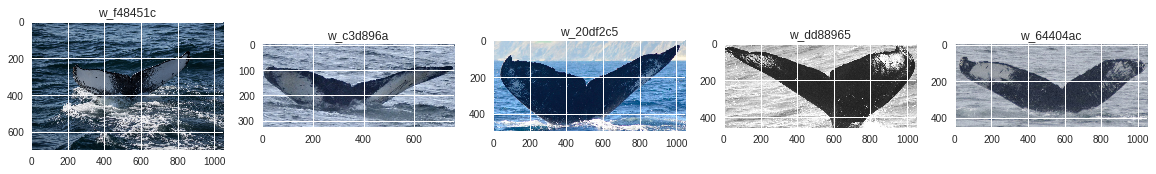

In [11]:
train_df = pd.read_csv("./train.csv")

seq = train_df['Id'] != 'new_whale'
train_df = train_df[seq]

img_path = './train/'

#get the first 5 whale images
images = [(whale_img, whale_label) for (whale_img, whale_label) in zip(train_df.Image[:5], train_df.Id[:5])]

fig, m_axs = plt.subplots(1, len(images), figsize = (20, 10))
#show the images and label them
for ii, c_ax in enumerate(m_axs):
    c_ax.imshow(imread(os.path.join(img_path,images[ii][0])))
    c_ax.set_title(images[ii][1])

#how many photos of each whail    
train_df.Id.value_counts()

In [12]:
# Make test directory

from distutils.dir_util import copy_tree

#create directories
if not os.path.exists('./test_folder'):
  os.mkdir('./test_folder')
  os.mkdir('./test_folder/test_images')

# copy subdirectory example
fromDirectory = './test'
toDirectory = "test_folder/test_images"

copy_tree(fromDirectory, toDirectory, verbose=1)

['test_folder/test_images/750bc81a3.jpg',
 'test_folder/test_images/117d8880c.jpg',
 'test_folder/test_images/cfd66546a.jpg',
 'test_folder/test_images/dfc94bfc2.jpg',
 'test_folder/test_images/a40379708.jpg',
 'test_folder/test_images/0b9b6b8ef.jpg',
 'test_folder/test_images/4e7b8030d.jpg',
 'test_folder/test_images/4b8943e01.jpg',
 'test_folder/test_images/ab32aa919.jpg',
 'test_folder/test_images/180d97933.jpg',
 'test_folder/test_images/bff0f1a93.jpg',
 'test_folder/test_images/2a9533d1c.jpg',
 'test_folder/test_images/c734d3c29.jpg',
 'test_folder/test_images/0c533e95a.jpg',
 'test_folder/test_images/7674275c4.jpg',
 'test_folder/test_images/2a8457c08.jpg',
 'test_folder/test_images/db9f2937c.jpg',
 'test_folder/test_images/def4c023e.jpg',
 'test_folder/test_images/a573c0926.jpg',
 'test_folder/test_images/46e1c45d7.jpg',
 'test_folder/test_images/3bf582861.jpg',
 'test_folder/test_images/860cc703b.jpg',
 'test_folder/test_images/ff4db73bd.jpg',
 'test_folder/test_images/80bdfc4c

In [13]:
#Image size
sz = 128

# create generators

data_gen_args = dict(rotation_range=20,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)

datagen=image.ImageDataGenerator(rescale=1./255, validation_split = 0.1,**data_gen_args)
test_datagen = image.ImageDataGenerator(rescale=1./255)

train_generator=datagen.flow_from_dataframe(
    dataframe=train_df, directory=img_path, 
    x_col="Image", y_col="Id", has_ext=True, seed = 42,
    class_mode="categorical", target_size=(sz,sz), batch_size=16, subset = "training")

validation_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=img_path, 
    x_col="Image", y_col="Id", has_ext=True, seed = 42,
    class_mode="categorical", target_size=(sz,sz), batch_size=16, subset = "validation")



test_generator = test_datagen.flow_from_directory(directory="test_folder", 
    seed = 42, class_mode=None, target_size=(sz,sz), batch_size=1, shuffle = False)

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=validation_generator.n//validation_generator.batch_size

Found 14155 images belonging to 5004 classes.
Found 1542 images belonging to 5004 classes.
Found 7960 images belonging to 1 classes.


In [14]:
#Training metrices
from keras.metrics import top_k_categorical_accuracy

''' the function top_5_accuracy is from Peter's kernel:
    https://www.kaggle.com/pestipeti/keras-cnn-starter
'''
def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

#Create the model
  
model = Sequential()



model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
model_vgg16_conv.summary()

#Create your own input format (here 3x200x200)
inputs = Input(shape=(sz, sz, 3))

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(inputs)

#Add the fully-connected layers 
x = Flatten()(output_vgg16_conv)
x = Dense(5004, activation='Relu')(x)
x = Dense(5004, activation='softmax', name='predictions')(x)

#Create your own model 
model = Model(input=inputs, output=x)

model.compile(optimizer= Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy', top_5_accuracy])
model.summary()
checkpointer = ModelCheckpoint(filepath='weights.hdf5', 
                               verbose=1, save_best_only=True)

early_stopping = EarlyStopping(monitor = 'val_loss', patience = 5)


# Train the model
history= model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=2, callbacks = [checkpointer, early_stopping])

58892288/58889256 [==============================] - 6s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`


Epoch 1/2
884/884 [==============================] - 327s 370ms/step - loss: 8.3599 - acc: 0.0030 - top_5_accuracy: 0.0120 - val_loss: 8.3099 - val_acc: 0.0039 - val_top_5_accuracy: 0.0137

Epoch 00001: val_loss improved from inf to 8.30993, saving model to weights.hdf5
Epoch 2/2
884/884 [==============================] - 292s 331ms/step - loss: 8.0699 - acc: 0.0042 - top_5_accuracy: 0.0193 - val_loss: 8.4044 - val_acc: 0.0039 - val_top_5_accuracy: 0.0190

Epoch 00002: val_loss did not improve from 8.30993


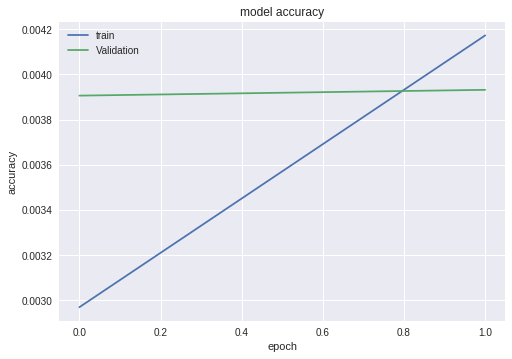

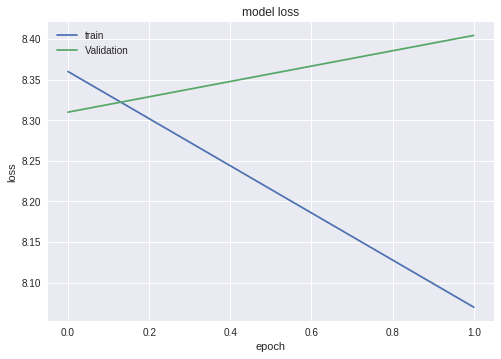

In [15]:
#plot history

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'Validation'], loc='upper left')
plt.show()

In [16]:
#we need to use .reset() here otherwise
#the other of predictions will be different
#then the expected
test_generator.reset()
pred = model.predict_generator(test_generator,verbose = 1,steps=7960)

7960/7960 [==============================] - 138s 17ms/step


In [17]:
'''This filters only the top 5 possible ids of an image'''
pred_sorted = np.argsort(-pred, axis = 1)[:,:5]
pred_sorted

array([[ 165,   17,   57,  264,  415],
       [  17,  165,   57, 1286,  264],
       [  17,  165,   57,  415, 1286],
       ...,
       [  17,  165,   57, 1286,  264],
       [  17,  165,   57,  415,  714],
       [ 165,   17,   57, 1286,  264]])

In [0]:
'''
Now we generate a map of each 
index to an Id on the format 
{
0: 'w_f48451c',
1: 'w_c3d896a',
2: 'w_20df2c5',
...
}
'''
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())

In [19]:
'''
Here we prepare pred_ids, which is a list of lists containing 
the top 5 ids by name. For example, w_13ae3d4. 
'''
from tqdm import tqdm
#create empty list
pred_ids = list()
for i,row in enumerate(tqdm(pred_sorted)):
    #create a temporary list to store the ids for a given image
    temp_list = []
    for j,value in enumerate(row):
        #for each index in pred_sorted, append the real Id in temp_list
        temp_list.append(labels[row[j]])
    #append all 5 ids for a given image to pred_ids
    #effectively creating a similar list to pred_sorted
    #but with the real ids
    pred_ids.append(temp_list)

100%|██████████| 7960/7960 [00:00<00:00, 166439.81it/s]


In [0]:
'''create the final predictions by using all ids in a single string'''
final_preds = []
for i,top_5_ids in enumerate(pred_ids):
    final_preds.append(' '.join(pred_ids[i]))

In [0]:
'''delete the files on disk - otherwise the Kaggle kernel will throw an error'''
import shutil
shutil.rmtree('test_folder', ignore_errors=True)

In [22]:
submission = pd.DataFrame({"Image": os.listdir('./test'), "Id": final_preds})
submission = submission[['Image','Id']]
submission.to_csv("submission.csv", index = False, columns=['Image', 'Id'])
submission.head()



,Image,Id
0,750bc81a3.jpg,w_23a388d w_9c506f6 w_0369a5c w_9b5109b w_fd3e556
1,117d8880c.jpg,w_9c506f6 w_23a388d w_0369a5c w_2b069ba w_9b5109b
2,cfd66546a.jpg,w_9c506f6 w_23a388d w_0369a5c w_fd3e556 w_2b069ba
3,dfc94bfc2.jpg,w_23a388d w_9c506f6 w_0369a5c w_fd3e556 w_9b5109b
4,a40379708.jpg,w_9c506f6 w_23a388d w_0369a5c w_2b069ba w_9b5109b


In [23]:
!kaggle competitions submit -c humpback-whale-identification -f submission.csv -m "I wonder"

100% 498k/498k [00:05<00:00, 88.2kB/s]
Successfully submitted to Humpback Whale Identification